In [1]:
#three ways of finding time lag.from tqdm import tqdm

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import astropy
from astropy.io import fits
from astropy.table import Table
from astropy.timeseries import TimeSeries
from astropy.time import Time
from astropy.timeseries import TimeSeries, aggregate_downsample
from astropy.coordinates import match_coordinates_sky as coords

from PIL import Image

import warnings
warnings.filterwarnings('ignore')

from mid_IR_variables import fileIO_processing as fp
from mid_IR_variables import lightcurve_processing as lp
from mid_IR_variables import ZTF_lightcurve_processing as zlp
from mid_IR_variables import reverberation_mapper 
from mid_IR_variables import MCMC_sampler


from sklearn.gaussian_process import GaussianProcessRegressor, kernels

from scipy import optimize
import scipy.stats as stats

import os

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 22})
matplotlib.rc('font',**{'family':'serif','serif':['Times']})
matplotlib.rc('text', usetex=True)

SAVE_FILEPATH = 'C:/Users/paiaa/Documents/Research/Blanton Lab/Midir Variables/Figures/'
IMPORT_FILEPATH ='C:/Users/paiaa/Documents/Research/Blanton Lab/Midir Variables/'

mnsa_hdu, manga_wise_hdu, pipe3d_hdu = fp.import_manga(6, 1, 1)
mnsa, mwv, pipe3d = mnsa_hdu.data, manga_wise_hdu.data, pipe3d_hdu.data


In [2]:
def averaged_ccf(plateifu, iterations, wise_band):

    lmins = np.linspace(0.07, 1.95, iterations)
    lmaxs = np.linspace(0.09, 2.05, iterations)
    #GP for optical data
    optical_data =  lp.generate_combined_lightcurve(pifu=plateifu)
    
    if wise_band == 1:
        wise = fp.process_wise(pifu, mwv, band=1)
    if wise_band == 2:
        wise = fp.process_wise(pifu, mwv, band=2)


    gps, hyperparams = [], []

    ccfs, time_lags = [], []
    for i in range(iterations):
        print('iteration:', str(i))
        poly_subtracted_obj_p, fit, fitted_poly = lp.polyfit_lightcurves(optical_data, deg=10)
        gp, llh, hyperparam, cov = lp.GP(poly_subtracted_obj_p, kernel_num=3, lengthscale=(lmins[i], lmaxs[i]))
        gp_fitted_poly =lp.make_polynomial(test_gp, fit)

        gp['mag']+=gp_fitted_poly

        cross_corr_func, time_lag = ccf(gp, wise)

        gps.append(gp)
        hyperparams.append(hyperparam)
        ccfs.append(cross_corr_func)
        time_lags.append(time_lag)

    return gps, hyperparams, ccfs, time_lags

In [52]:
pifus = np.array([ '10223-3701', '9000-1901', '7977-9101', '9186-9101','8091-6101', '9487-9102', '8593-12705', '8615-3701','7981-9102', '8341-12704', 
                  '8466-3704', '8561-3704', '8091-9101', '9870-9101', '9514-1901', '9487-3702', '8710-6102', '11833-3702', '11944-12704', 
                  '8553-1901', '12071-12703', '9887-1901', '10516-12701', '7815-6104', '8132-6101', '8612-1901', '8619-12702', '9497-12705', '9502-12703',
                    '12483-9102', '12511-3702', '8326-6102', '8714-3704', '8999-3702'])

##IMPORTANT: For 8999-3702, Max whitekernel noise = 0.5
print(pifus.shape[0])
pifu = '8091-9101'##pifus[0]
print(pifu)
#os.makedirs(SAVE_FILEPATH+"/Reverb_Lags/plateifu/"+pifu, exist_ok=True)

34
8091-9101


In [63]:

#pifu = '11944-12704' #pifus[10]
RM = reverberation_mapper.reverberation_mapper(pifu)

minimizer_args = {"model":'brute', "x0":[0.2, 1, 1], "ranges": ((0, 3.5, 0.01),), "wise band": 1, "verbose": 0}
model1 = RM.minimize_chisq(minimizer_args)
m1 = model1[0]

minimizer_args = {"model":'brute', "x0":[0.2, 1, 1], "ranges": ((0, 3.5, 0.01),), "wise band": 2, "verbose": 0}
model2 = RM.minimize_chisq(minimizer_args)
m2 = model2[0]

**GP Kernel: 1.2**2 * RBF(length_scale=0.95) + WhiteKernel(noise_level=0.689)**
**Optical Data and GP Generated**
**IR Data Generated**


In [64]:
a = np.where(RM.chisq_w1 == np.nanmin(RM.chisq_w1))[0][0]
b = np.where(RM.chisq_w2 == np.nanmin(RM.chisq_w2))[0][0]

ccf_w1, lag_w1 = reverberation_mapper.ccf(RM.optical_GP, RM.w1, 1)
conv_m_opt1, conv_t_opt1, err_opt1 = RM.convolve(m1, 0.5) #[0]


if ccf_w1.size>0:
    c = np.where(ccf_w1 == np.max(ccf_w1))[0][0]
else:
    c=0
    
ccf_w2, lag_w2 = reverberation_mapper.ccf(RM.optical_GP, RM.w2, 2)
conv_m_opt2, conv_t_opt2, err_op2 = RM.convolve(m2, 0.5) #[0]


if ccf_w2.size>0:
    d = np.where(ccf_w2 == np.max(ccf_w2))[0][0]
else:
    d=0

m1 = np.append(m1, RM.amp1[a])
m1 = np.append(m1, RM.const1[a])
m2 = np.append(m2, RM.amp2[b])
m2 = np.append(m2, RM.const2[b])
print(m1, m2)

[ 0.          1.28510649 14.80039302] [ 0.04        2.24118449 15.36342522]


Text(0, 0.5, '$\\chi^2$ value (W2)')

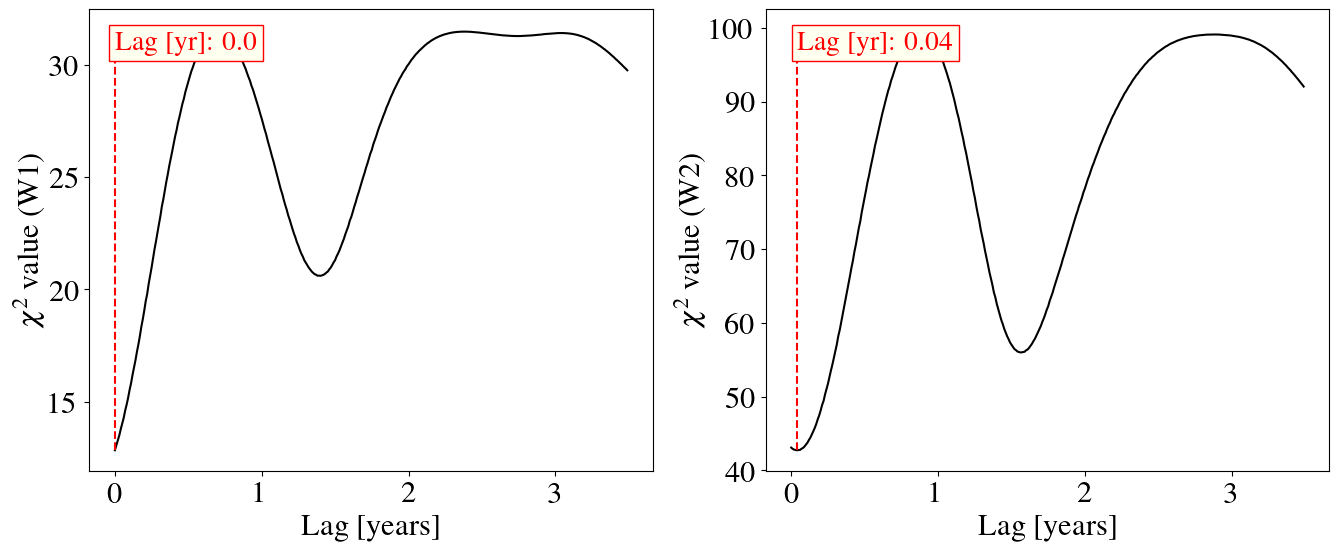

In [65]:
fig, ax = plt.subplots(figsize=(16,6), ncols=2)

ax[0].plot(model1[2], model1[3], c='k')
ax[0].vlines(m1[0], np.nanmin(model1[3]), np.nanmax(model1[3]), color='r', ls='dashed')
ax[0].text(m1[0], np.nanmax(model1[3]), 'Lag [yr]: '+str(np.round(m1[0],2)), ha='left', va='top', c='r', fontsize=20, bbox=dict(facecolor='ivory', edgecolor='r', alpha=1), zorder=5)
   
ax[0].set_xlabel('Lag [years]')
ax[0].set_ylabel(r'$\chi^2$ value (W1)')

ax[1].plot(model2[2], model2[3], c='k')
ax[1].vlines(m2[0], np.nanmin(model2[3]), np.nanmax(model2[3]), color='r', ls='dashed')
ax[1].text(m2[0], np.nanmax(model2[3]), 'Lag [yr]: '+str(np.round(m2[0],2)), ha='left', va='top', c='r', fontsize=20, bbox=dict(facecolor='ivory', edgecolor='r', alpha=1), zorder=5)
   
ax[1].set_xlabel('Lag [years]')
ax[1].set_ylabel(r'$\chi^2$ value (W2)')

#plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'chisq.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

In [56]:
# print(model1[3].shape, model2[3].shape)
# fig, ax = plt.subplots(figsize=(14,6), ncols=2)
# im1 = ax[0].imshow(model1[3][:,:].T, norm=matplotlib.colors.LogNorm())

# ax[0].set_ylabel('amplitude (W1)')
# ax[0].set_xlabel('lag [yr]')

# cax = fig.add_axes([ax[0].get_position().x1+0.01,ax[0].get_position().y0,0.02,ax[0].get_position().height])
# cbar = plt.colorbar(im1, cax=cax)
# cbar.set_label(r'$\chi^2$ value')
# xticks=np.linspace(0, model1[3].shape[0], 5)
# ax[0].set_xticks(xticks);

# xticklabels=np.round(np.linspace(0.04, 1.5, 5), 2)
# ax[0].set_xticklabels(xticklabels);

# yticks=np.linspace(0,  model1[3].shape[1], 6)
# ax[0].set_yticks(yticks);

# yticklabels=np.round(np.linspace(0.01, 10, 6), 1)
# ax[0].set_yticklabels(yticklabels);

# im2 = ax[1].imshow(model2[3][:,:].T, norm=matplotlib.colors.LogNorm())

# ax[1].set_ylabel('amplitude (W2)')
# ax[1].set_xlabel('lag [yr]')

# cax = fig.add_axes([ax[1].get_position().x1+0.01,ax[1].get_position().y0,0.02,ax[1].get_position().height])
# cbar = plt.colorbar(im2, cax=cax)
# cbar.set_label(r'$\chi^2$ value')
# xticks=np.linspace(0, model2[3].shape[0], 5)
# ax[1].set_xticks(xticks);

# xticklabels=np.round(np.linspace(0.04, 1.5, 5), 2)
# ax[1].set_xticklabels(xticklabels);

# yticks=np.linspace(0,  model2[3].shape[1], 6)
# ax[1].set_yticks(yticks);

# yticklabels=np.round(np.linspace(0.01, 10, 6), 1)
# ax[1].set_yticklabels(yticklabels);

#plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'chisq.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

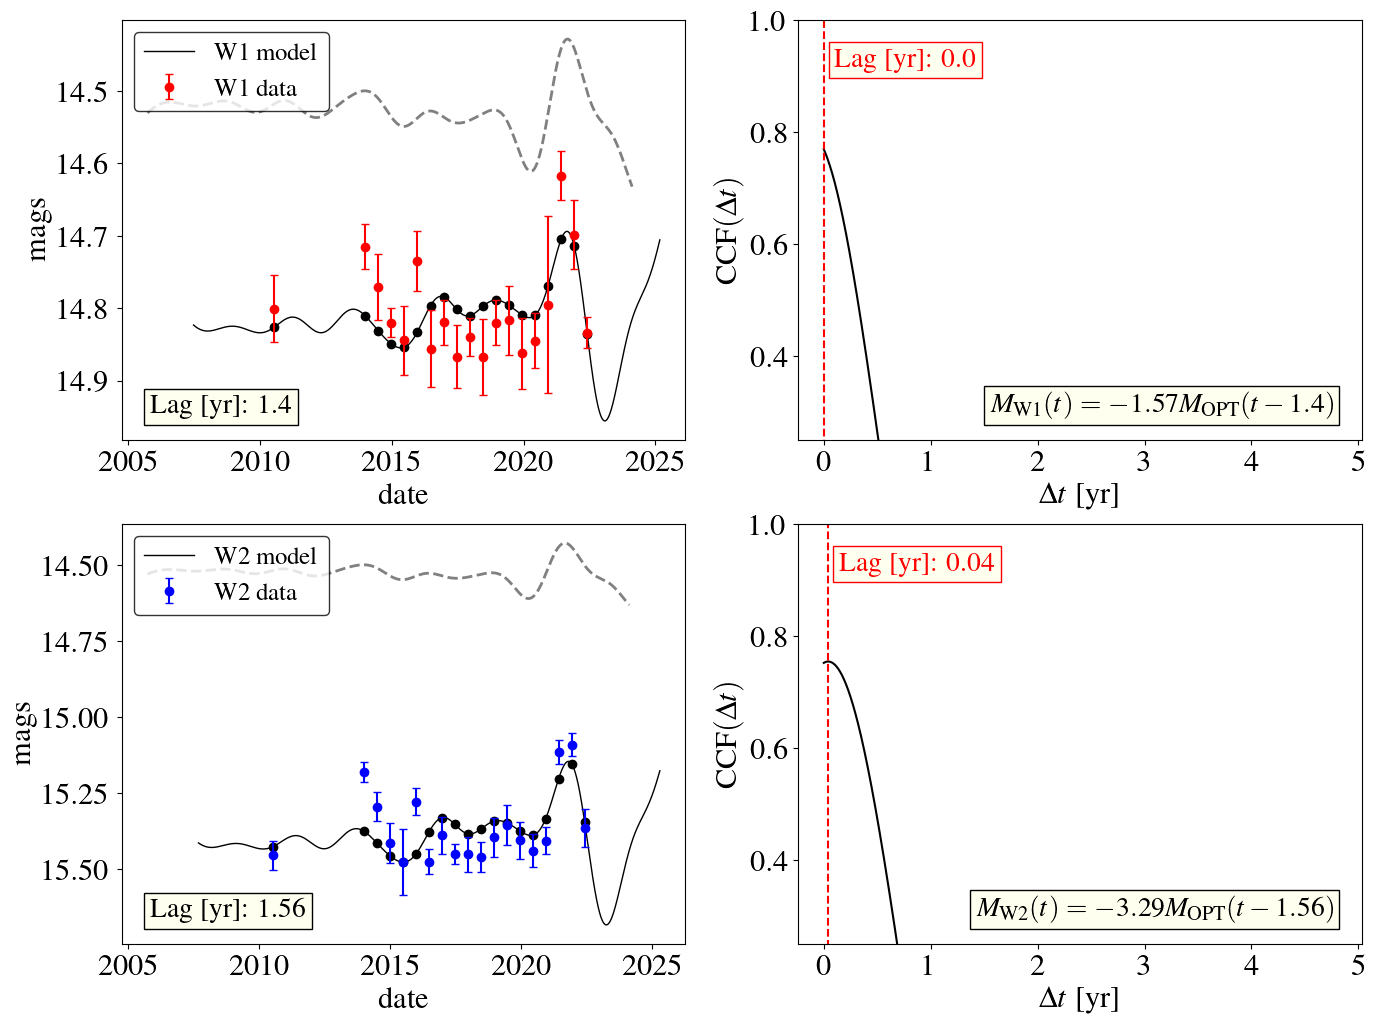

In [57]:
fig, ax = plt.subplots(figsize=(16,12), ncols=2, nrows=2)
ax[0, 0].plot(RM.optical_GP['time'].to_value('decimalyear'), RM.optical_GP['mag'], c='grey', lw=2, ls='dashed')
#ax[0].fill_between(RM.optical_GP['time'].to_value('decimalyear')+m1[0], m1[1]*RM.optical_GP['mag']+m1[2]-RM.optical_GP['mag_err'], m1[1]*RM.optical_GP['mag']+m1[2]+RM.optical_GP['mag_err'], color='cornflowerblue', alpha=0.5)

ax[0, 0].plot(conv_t_opt1+m1[0], RM.model1[a], c='k', lw=1, label='W1 model', zorder=-1)
ax[0, 0].scatter(RM.t_w1,  RM.preds_w1[a], c='k')
ax[0, 0].errorbar(RM.t_w1, RM.m_w1, yerr=RM.err_w1, c='red', capsize=3, linestyle='none', marker='o', label='W1 data')
ax[0, 0].text(0.05, 0.05, 'Lag [yr]: '+str(np.round(m1[0],3)), ha='left', va='bottom', fontsize=20, transform=ax[0, 0].transAxes, bbox=dict(facecolor='ivory', edgecolor='k', alpha=1), zorder=5)

ax[0, 0].invert_yaxis()
ax[0, 0].legend(edgecolor='k', loc='upper left', fontsize=18)
ax[0, 0].set_ylabel('mags')
ax[0, 0].set_xlabel('date')

if ccf_w1.size>0:
    ax[0, 1].plot(lag_w1, ccf_w1, lw=1.5, c='k')
    ax[0, 1].vlines(lag_w1[c], 0, 1, color='r', ls='dashed')
    ax[0, 1].text(lag_w1[c]+0.1, 0.95, 'Lag [yr]: '+str(np.round(lag_w1[c],3)), ha='left', va='top', c='r', fontsize=20, bbox=dict(facecolor='ivory', edgecolor='r', alpha=1), zorder=5)
    ax[0, 1].text(0.95, 0.05, r'$M_{\rm W1}(t)='+str(np.round(m1[1], 2))+r'M_{\rm OPT}(t-'+str(np.round(m1[0],3))+')$', ha='right', va='bottom', fontsize=20, transform=ax[0, 1].transAxes, bbox=dict(facecolor='ivory', edgecolor='k', alpha=1), zorder=5)

    ax[0, 1].set_ylabel(r'CCF$(\Delta t)$')
    ax[0, 1].set_ylim(0.25, 1)
    ax[0, 1].set_xlabel(r'$\Delta t$ [yr]')
else:
    ax[0, 1].axis("off")
# ax[0, 0].set_ylim(12, 13.5)
# ax[0].sharey(ax[0, 1])




ax[1, 0].plot(RM.optical_GP['time'].to_value('decimalyear'), RM.optical_GP['mag'], c='grey', lw=2, ls='dashed')
# ax[0].fill_between(RM.optical_GP['time'].to_value('decimalyear')+m2[0], m2[1]*RM.optical_GP['mag']+m2[2]-RM.optical_GP['mag_err'], m2[1]*RM.optical_GP['mag']+m2[2]+RM.optical_GP['mag_err'], color='cornflowerblue', alpha=0.5)

ax[1, 0].plot(conv_t_opt2+m2[0], RM.model2[b], c='k', lw=1, label='W2 model', zorder=-1)
ax[1, 0].scatter(RM.t_w2,  RM.preds_w2[b], c='k')
ax[1, 0].errorbar(RM.t_w2, RM.m_w2, yerr=RM.err_w2, c='blue', capsize=3, linestyle='none', marker='o', label='W2 data')
ax[1, 0].text(0.05, 0.05, 'Lag [yr]: '+str(np.round(m2[0],3)), ha='left', va='bottom', fontsize=20, transform=ax[1, 0].transAxes, bbox=dict(facecolor='ivory', edgecolor='k', alpha=1), zorder=5)


ax[1, 0].invert_yaxis()
ax[1, 0].legend(edgecolor='k', loc='upper left', fontsize=18)
ax[1, 0].set_ylabel('mags')
ax[1, 0].set_xlabel('date')
  
# ax[0].sharey(ax[0, 1])

if ccf_w2.size>0:
    ax[1, 1].plot(lag_w2, ccf_w2, lw=1.5, c='k')
    ax[1, 1].vlines(lag_w2[d], 0, 1, color='r', ls='dashed')
    ax[1, 1].text(lag_w2[d]+0.1, 0.95, 'Lag [yr]: '+str(np.round(lag_w2[d],3)), ha='left', va='top', c='r', fontsize=20, bbox=dict(facecolor='ivory', edgecolor='r', alpha=1), zorder=5)
    ax[1, 1].text(0.95, 0.05, r'$M_{\rm W2}(t)='+str(np.round(m2[1], 2))+r'M_{\rm OPT}(t-'+str(np.round(m2[0],3))+')$', ha='right', va='bottom', fontsize=20, transform=ax[1, 1].transAxes, bbox=dict(facecolor='ivory', edgecolor='k', alpha=1), zorder=5)

    ax[1, 1].set_ylabel(r'CCF$(\Delta t)$')
    ax[1, 1].set_ylim(0.25, 1)
    ax[1, 1].set_xlabel(r'$\Delta t$ [yr]')
else:
    ax[1, 1].axis("off")
    
#plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'lightcurve.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

In [58]:
mcmc = MCMC_sampler.MCMC(RM.optical_GP, RM.w1)

initial = m1
p0 = [np.array(initial[:]) +  np.random.normal(loc=0, scale=0.5, size=3) for i in range(100)]
# p0 = np.insert(p0, 0, np.random.normal(loc=0, scale=0.5, size=3), axis=1)

mcmc_args = {"initial":initial, "p0": p0, "ranges":((-1.5, 1.5), (-100, 100), (-100, 100)), "width": 0.5, "nwalkers": 100, "niter": 250}
mcmc.run_MCMC(mcmc_args)

Running burn-in...
Running production...


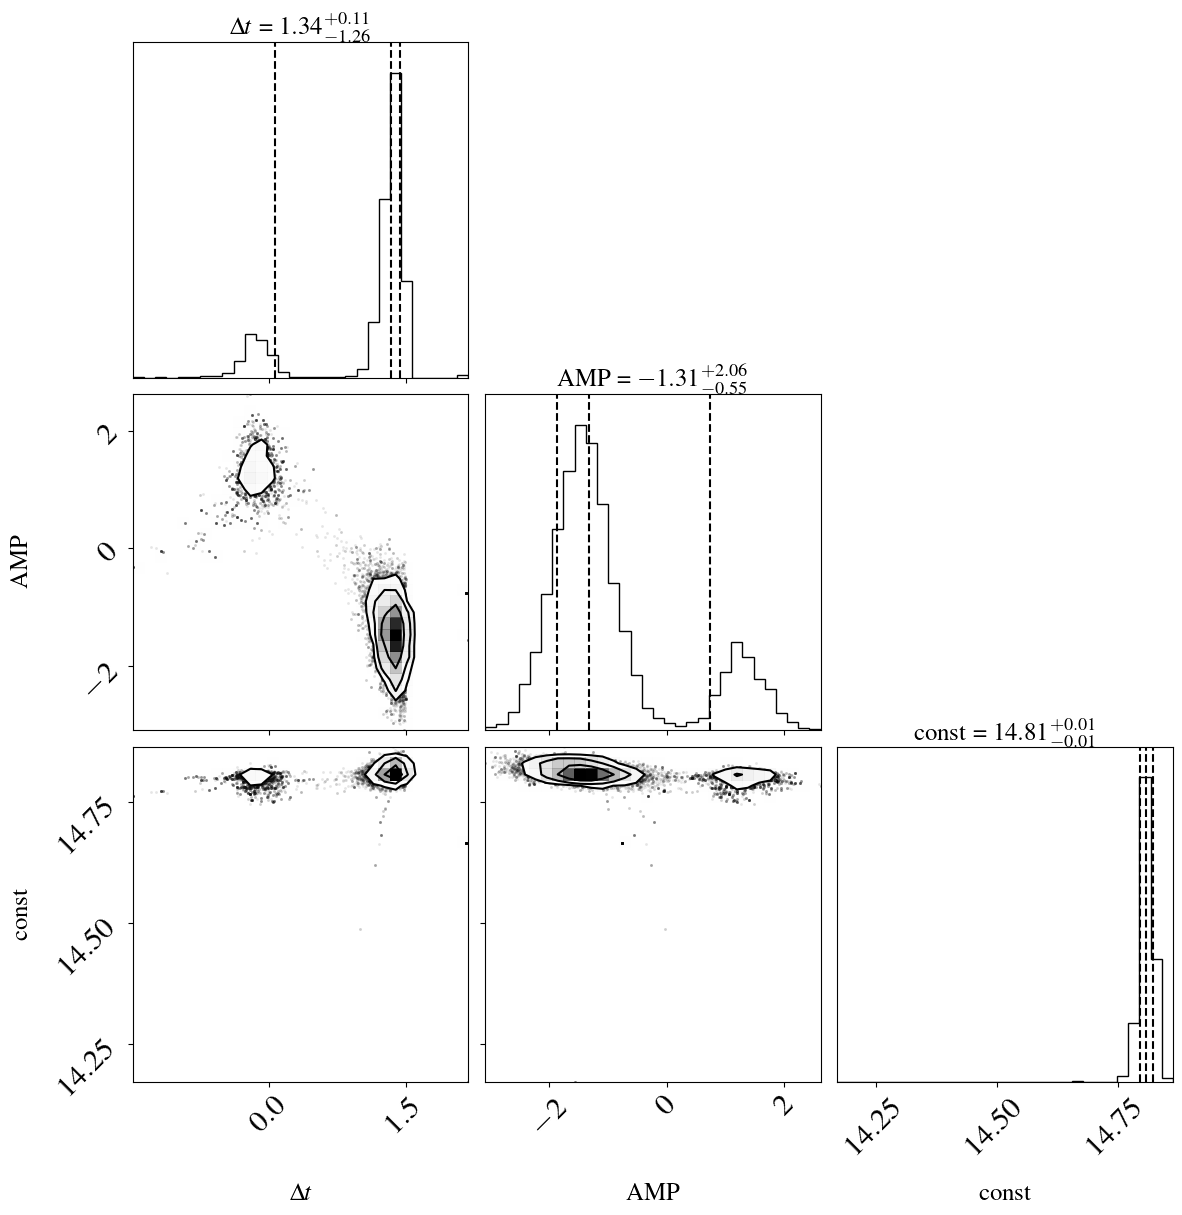

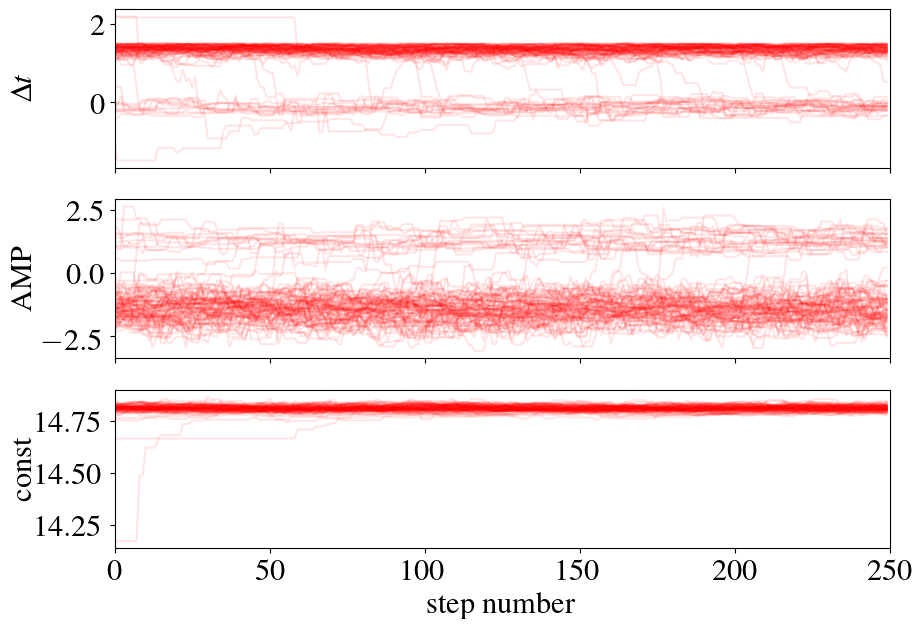

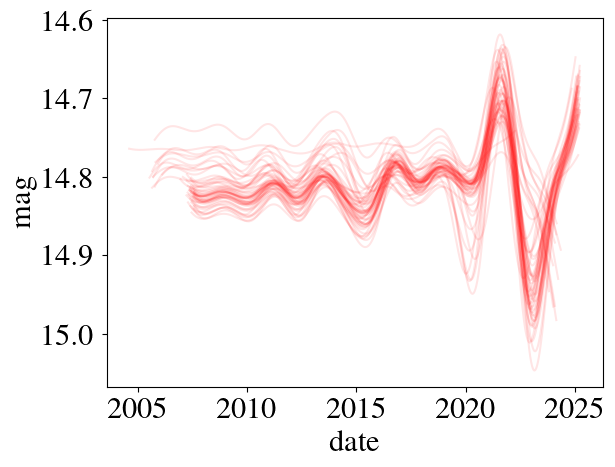

In [59]:
plotter_args = {"label": [r'$\Delta t$', 'AMP', 'const'], "color": "r", "num": 50, "alpha": 0.1}
CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=18),
    labels = [r'$\Delta t$', 'AMP', 'const'],
    title_kwargs=dict(fontsize=18),
    quantiles=[0.16, 0.5, 0.84],
    #levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=True,
    plot_datapoints=True,
    #fill_contours=1,
    show_titles=True,
    max_n_ticks=3,
    title_fmt=".2f",
    bins=30
)
mcmc.generate_corner_plot(CORNER_KWARGS)
#plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'mcmc_w1.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)
mcmc.generate_walker_path_plot(plotter_args)
#plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'walkers_w1.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)
mcmc.generate_monte_carlos_plot(plotter_args)
#plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'montecarlo_w1.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)


In [60]:
mcmc.set_IR_data(RM.w2)

initial = m2
p0 = [np.array(initial[:]) +  np.random.normal(loc=0, scale=0.5, size=3) for i in range(100)]
# p0 = np.insert(p0, 0, np.random.normal(loc=0, scale=0.5,size=len(p0)), axis=1)
mcmc_args = {"initial":initial, "p0": p0, "ranges":((-1.5, 1.5), (-100, 100), (-100, 100)), "width": 0.5, "nwalkers": 100, "niter": 250}
mcmc.run_MCMC(mcmc_args)

Running burn-in...
Running production...


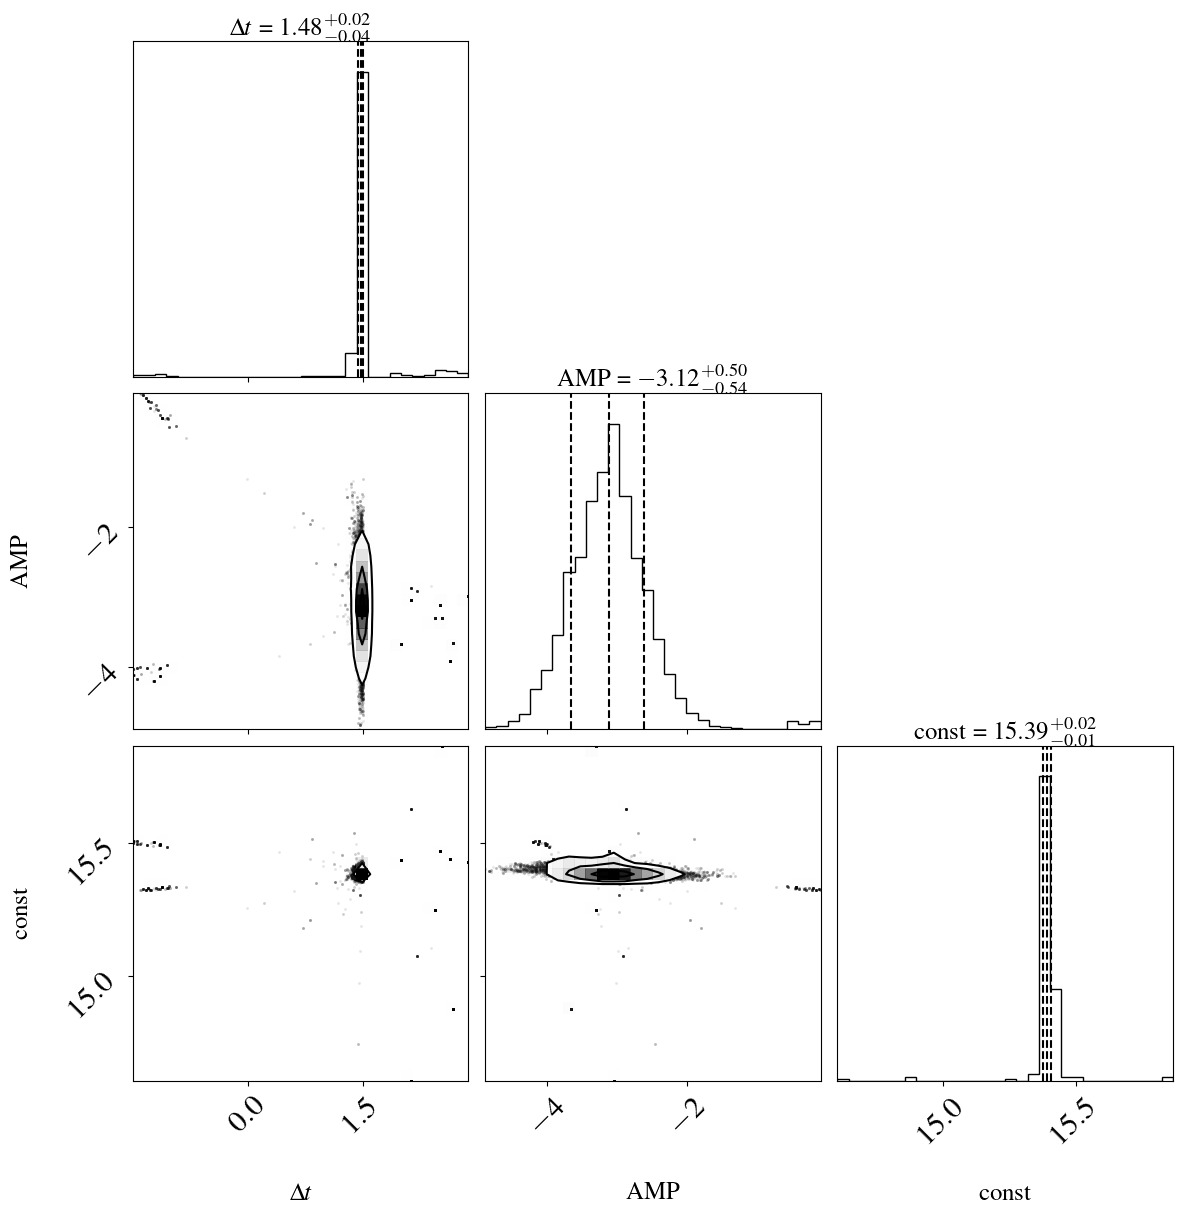

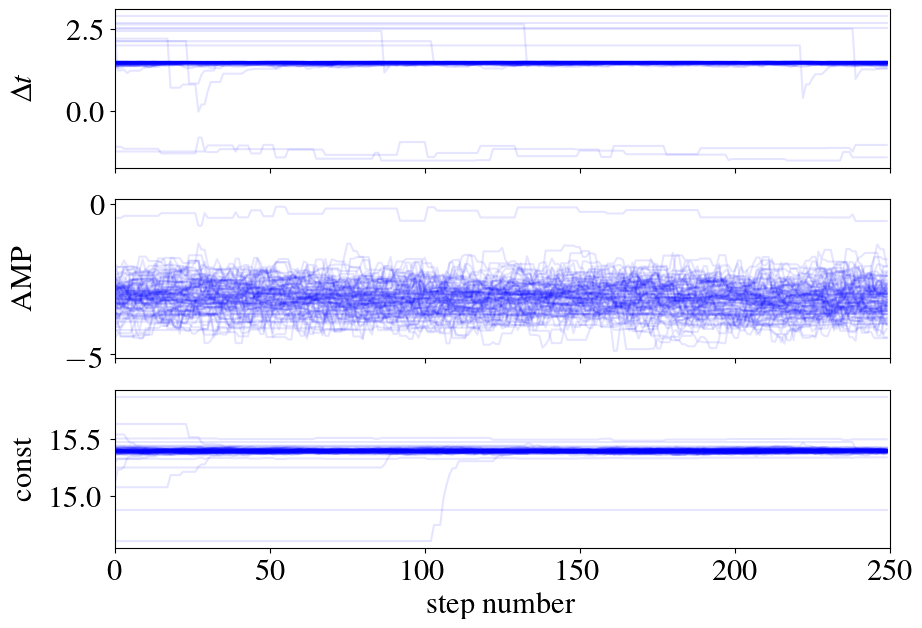

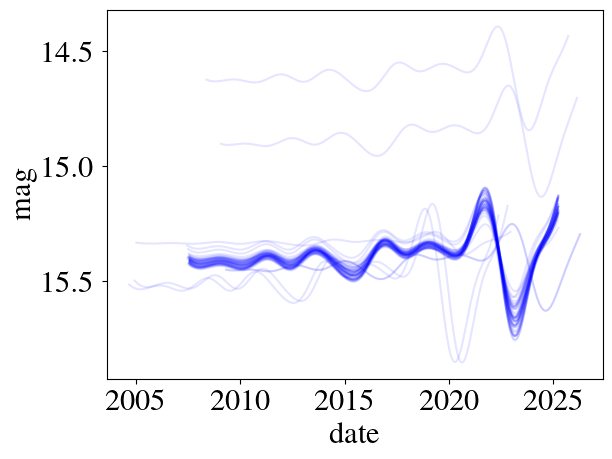

In [61]:
plotter_args = {"label": [r'$\Delta t$', 'AMP', 'const'], "color": "blue", "num": 50, "alpha": 0.1}

mcmc.generate_corner_plot(CORNER_KWARGS)
#plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'mcmc_w2.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)
mcmc.generate_walker_path_plot(plotter_args)
#plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'walkers_w2.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)
mcmc.generate_monte_carlos_plot(plotter_args)
#plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'montecarlo_w2.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

In [62]:
assert False

AssertionError: 

In [ ]:
tab = Table(names=['plateifu', 'lag_w1', 'amp_w1', 'const_w1', 'lag_w2', 'amp_w2', 'const_w2', 'lag_w1_yerr_max', 'lag_w1_yerr_min', 'lag_w2_yerr_max', 'lag_w2_yerr_min'], 
            dtype=[str, np.float64, np.float64, np.float64, np.float64, np.float64, np.float64, np.float64, np.float64, np.float64, np.float64])

pifus = np.array([ '10223-3701', '9000-1901', '7977-9101', '9186-9101','8091-6101', '9487-9102', '8593-12705', '8615-3701','7981-9102', '8341-12704', 
                  '8466-3704', '8561-3704', '7815-6104', '8091-9101', '9870-9101', '9514-1901', '9487-3702', '8710-6102', '11833-3702', '11944-12704', 
                  '8553-1901', '12071-12703', '9887-1901', '10516-12701', '7815-6104', '8132-6101', '8612-1901', '8619-12702', '9497-12705', '9502-12703',
                    '12483-9102', '12511-3702', '8326-6102', '8714-3704', '8999-3702'])
for i, pifu in enumerate(pifus[:]):
    print("object", str(i), "of", str(pifus.shape[0]))
    print(pifu)
    os.makedirs(SAVE_FILEPATH+"/Reverb_Lags/plateifu/"+pifu, exist_ok=True)




    RM = reverberation_mapper.reverberation_mapper(pifu)
    
    minimizer_args = {"model":'brute', "x0":[0.2, 1, 1], "ranges": ((-3, 3, 0.01),), "wise band": 1, "verbose": 0}
    model1 = RM.minimize_chisq(minimizer_args)
    m1 = model1[0]

    minimizer_args = {"model":'brute', "x0":[0.2, 1, 1], "ranges": ((-3, 3, 0.01),), "wise band": 2, "verbose": 0}
    model2 = RM.minimize_chisq(minimizer_args)
    m2 = model2[0]



    ccf_w1, lag_w1 = reverberation_mapper.ccf(RM.optical_GP, RM.w1, 1)
    conv_m_opt1, conv_t_opt1, err_opt1 = RM.convolve(m1)

    a = np.where(RM.chisq_w1 == np.nanmin(RM.chisq_w1))[0][0]

    if ccf_w1.size>0:
        c = np.where(ccf_w1 == np.max(ccf_w1))[0][0]  #[:ccf_w1.size//3]
    else:
        c=0
        
    ccf_w2, lag_w2 = reverberation_mapper.ccf(RM.optical_GP, RM.w2, 2)
    conv_m_opt2, conv_t_opt2, err_op2 = RM.convolve(m2)

    b = np.where(RM.chisq_w2 == np.nanmin(RM.chisq_w2))[0][0]

    if ccf_w2.size>0:
        d = np.where(ccf_w2 == np.max(ccf_w2))[0][0]  #[:ccf_w2.size//3]
    else:
        d=0

    m1 = np.append(m1, RM.amp1[a])
    m1 = np.append(m1, RM.const1[a])
    m2 = np.append(m2, RM.amp2[b])
    m2 = np.append(m2, RM.const2[b])
    
    print(m1, m2)
    fig, ax = plt.subplots(figsize=(16,6), ncols=2)

    ax[0].plot(model1[2], model1[3], c='k')
    ax[0].vlines(m1[0], np.nanmin(model1[3]), np.nanmax(model1[3]), color='r', ls='dashed')
    ax[0].text(m1[0], np.nanmax(model1[3]), 'Lag [yr]: '+str(np.round(m1[0],2)), ha='left', va='top', c='r', fontsize=20, bbox=dict(facecolor='ivory', edgecolor='r', alpha=1), zorder=5)
    
    ax[0].set_xlabel('Lag [years]')
    ax[0].set_ylabel(r'$\chi^2$ value (W1)')

    ax[1].plot(model2[2], model2[3], c='k')
    ax[1].vlines(m2[0], np.nanmin(model2[3]), np.nanmax(model2[3]), color='r', ls='dashed')
    ax[1].text(m2[0], np.nanmax(model2[3]), 'Lag [yr]: '+str(np.round(m2[0],2)), ha='left', va='top', c='r', fontsize=20, bbox=dict(facecolor='ivory', edgecolor='r', alpha=1), zorder=5)
    
    ax[1].set_xlabel('Lag [years]')
    ax[1].set_ylabel(r'$\chi^2$ value (W2)')

    plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'chisq.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)
    plt.close()

    
    fig, ax = plt.subplots(figsize=(16,12), ncols=2, nrows=2)
    ax[0, 0].plot(RM.optical_GP['time'].to_value('decimalyear'), RM.optical_GP['mag'], c='grey', lw=2, ls='dashed')
    #ax[0].fill_between(RM.optical_GP['time'].to_value('decimalyear')+m1[0], m1[1]*RM.optical_GP['mag']+m1[2]-RM.optical_GP['mag_err'], m1[1]*RM.optical_GP['mag']+m1[2]+RM.optical_GP['mag_err'], color='cornflowerblue', alpha=0.5)

    ax[0, 0].plot(conv_t_opt1+m1[0], RM.model1[a], c='k', lw=1, label='W1 model', zorder=-1)
    ax[0, 0].scatter(RM.t_w1,  RM.preds_w1[a], c='k')
    ax[0, 0].errorbar(RM.t_w1, RM.m_w1, yerr=RM.err_w1, c='red', capsize=3, linestyle='none', marker='o', label='W1 data')
    ax[0, 0].text(0.05, 0.05, 'Lag [yr]: '+str(np.round(m1[0],3)), ha='left', va='bottom', fontsize=20, transform=ax[0, 0].transAxes, bbox=dict(facecolor='ivory', edgecolor='k', alpha=1), zorder=5)

    ax[0, 0].invert_yaxis()
    ax[0, 0].legend(edgecolor='k', loc='upper left', fontsize=18)
    ax[0, 0].set_ylabel('mags')
    ax[0, 0].set_xlabel('date')

    if ccf_w1.size>0:
        ax[0, 1].plot(lag_w1, ccf_w1, lw=1.5, c='k')
        ax[0, 1].vlines(lag_w1[c], 0, 1, color='r', ls='dashed')
        ax[0, 1].text(lag_w1[c]+0.1, 0.95, 'Lag [yr]: '+str(np.round(lag_w1[c],3)), ha='left', va='top', c='r', fontsize=20, bbox=dict(facecolor='ivory', edgecolor='r', alpha=1), zorder=5)
        ax[0, 1].text(0.95, 0.05, r'$M_{\rm W1}(t)='+str(np.round(m1[1], 2))+r'M_{\rm OPT}(t-'+str(np.round(m1[0],3))+')$', ha='right', va='bottom', fontsize=20, transform=ax[0, 1].transAxes, bbox=dict(facecolor='ivory', edgecolor='k', alpha=1), zorder=5)

        ax[0, 1].set_ylabel(r'CCF$(\Delta t)$')
        ax[0, 1].set_ylim(0.25, 1)
        ax[0, 1].set_xlabel(r'$\Delta t$ [yr]')
    else:
        ax[0, 1].axis("off")
    # ax[0, 0].set_ylim(12, 13.5)
    # ax[0].sharey(ax[0, 1])




    ax[1, 0].plot(RM.optical_GP['time'].to_value('decimalyear'), RM.optical_GP['mag'], c='grey', lw=2, ls='dashed')
    # ax[0].fill_between(RM.optical_GP['time'].to_value('decimalyear')+m2[0], m2[1]*RM.optical_GP['mag']+m2[2]-RM.optical_GP['mag_err'], m2[1]*RM.optical_GP['mag']+m2[2]+RM.optical_GP['mag_err'], color='cornflowerblue', alpha=0.5)

    ax[1, 0].plot(conv_t_opt2+m2[0], RM.model2[b], c='k', lw=1, label='W2 model', zorder=-1)
    ax[1, 0].scatter(RM.t_w2,  RM.preds_w2[b], c='k')
    ax[1, 0].errorbar(RM.t_w2, RM.m_w2, yerr=RM.err_w2, c='blue', capsize=3, linestyle='none', marker='o', label='W2 data')
    ax[1, 0].text(0.05, 0.05, 'Lag [yr]: '+str(np.round(m2[0],3)), ha='left', va='bottom', fontsize=20, transform=ax[1, 0].transAxes, bbox=dict(facecolor='ivory', edgecolor='k', alpha=1), zorder=5)


    ax[1, 0].invert_yaxis()
    ax[1, 0].legend(edgecolor='k', loc='upper left', fontsize=18)
    ax[1, 0].set_ylabel('mags')
    ax[1, 0].set_xlabel('date')
    
    # ax[0].sharey(ax[0, 1])

    if ccf_w2.size>0:
        ax[1, 1].plot(lag_w2, ccf_w2, lw=1.5, c='k')
        ax[1, 1].vlines(lag_w2[d], 0, 1, color='r', ls='dashed')
        ax[1, 1].text(lag_w2[d]+0.1, 0.95, 'Lag [yr]: '+str(np.round(lag_w2[d],3)), ha='left', va='top', c='r', fontsize=20, bbox=dict(facecolor='ivory', edgecolor='r', alpha=1), zorder=5)
        ax[1, 1].text(0.95, 0.05, r'$M_{\rm W2}(t)='+str(np.round(m2[1], 2))+r'M_{\rm OPT}(t-'+str(np.round(m2[0],3))+')$', ha='right', va='bottom', fontsize=20, transform=ax[1, 1].transAxes, bbox=dict(facecolor='ivory', edgecolor='k', alpha=1), zorder=5)

        ax[1, 1].set_ylabel(r'CCF$(\Delta t)$')
        ax[1, 1].set_ylim(0.25, 1)
        ax[1, 1].set_xlabel(r'$\Delta t$ [yr]')
    else:
        ax[1, 1].axis("off")
        
    plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'lightcurve.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)
    plt.close()

    mcmc = MCMC_sampler.MCMC(RM.optical_GP, RM.w1)

    initial = m1
    p0 = [np.array(initial[1:]) +  1e1 * np.random.randn(2) for i in range(100)]
    p0 = np.insert(p0, 0, np.random.normal(loc=0, scale=0.4, size=len(p0)), axis=1)

    mcmc_args = {"initial":initial, "p0": p0, "ranges":((-3, 3), (-100, 100), (-100, 100))}
    mcmc.run_MCMC(mcmc_args)

    
    plotter_args = {"label": [r'$\Delta t$', 'AMP', 'const'], "color": "r", "num": 50, "alpha": 0.1}
    CORNER_KWARGS = dict(
        label_kwargs=dict(fontsize=18),
        labels = [r'$\Delta t$', 'AMP', 'const'],
        title_kwargs=dict(fontsize=18),
        quantiles=[0.16, 0.5, 0.84],
        #levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
        plot_density=True,
        plot_datapoints=True,
        #fill_contours=1,
        show_titles=True,
        max_n_ticks=3,
        title_fmt=".2f",
        bins=30
    )
    mcmc.generate_corner_plot(CORNER_KWARGS)
    plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'mcmc_w1.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)
    plt.close()
    mcmc.generate_walker_path_plot(plotter_args)
    plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'walkers_w1.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)
    plt.close()
    mcmc.generate_monte_carlos_plot(plotter_args)
    plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'montecarlo_w1.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)
    plt.close()
    mcmc.set_IR_data(RM.w2)

    initial = m2
    p0 = [np.array(initial[1:]) + 1e1 * np.random.randn(2) for i in range(100)]
    p0 = np.insert(p0, 0, np.random.normal(loc=0, scale=0.4,size=len(p0)), axis=1)
    mcmc_args = {"initial":initial, "p0": p0, "ranges":((-3, 3), (-100, 100), (-100, 100))}
    mcmc.run_MCMC(mcmc_args)

    plotter_args = {"label": [r'$\Delta t$', 'AMP', 'const'], "color": "blue", "num": 50, "alpha": 0.1}

    mcmc.generate_corner_plot(CORNER_KWARGS)
    plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'mcmc_w2.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)
    plt.close()
    mcmc.generate_walker_path_plot(plotter_args)
    plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'walkers_w2.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)
    plt.close()
    mcmc.generate_monte_carlos_plot(plotter_args)
    plt.savefig(SAVE_FILEPATH+'Reverb_Lags/plateifu/'+pifu+'/'+'montecarlo_w2.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)
    plt.close()

object 0 of 34
10223-3701
using padded times
**GP Kernel: 3.57**2 * RBF(length_scale=0.95) + WhiteKernel(noise_level=0.672)**
**Optical Data and GP Generated**
**IR Data Generated**
[ 0.22        5.61294682 13.49074704] [ 2.95        6.52667786 13.68717144]
Running burn-in...
Running production...


Running burn-in...
Running production...
object 1 of 34
9000-1901
**GP Kernel: 3.2**2 * RBF(length_scale=0.95) + WhiteKernel(noise_level=0.399)**
**Optical Data and GP Generated**
**IR Data Generated**
[-6.39488462e-14  1.90135079e+00  1.39651505e+01] [ 0.1         2.02124684 13.88879767]
Running burn-in...
Running production...


Running burn-in...
Running production...


object 2 of 34
7977-9101
**GP Kernel: 88.2**2 * RBF(length_scale=0.95) + WhiteKernel(noise_level=0.359)**
**Optical Data and GP Generated**
**IR Data Generated**
[ 0.05        1.19528747 14.23106905] [ 0.25        1.55831488 14.51689588]
Running burn-in...
Running production...


Running burn-in...
Running production...


object 3 of 34
9186-9101
using padded times
**GP Kernel: 316**2 * RBF(length_scale=0.95) + WhiteKernel(noise_level=0.189)**
**Optical Data and GP Generated**
**IR Data Generated**
[ 2.99       -2.53827949 13.33994313] [ 2.99       -2.24817143 13.3185848 ]
Running burn-in...
Running production...


Running burn-in...
Running production...
object 4 of 34
8091-6101
**GP Kernel: 2.53**2 * RBF(length_scale=0.95) + WhiteKernel(noise_level=0.446)**
**Optical Data and GP Generated**
**IR Data Generated**
[ 0.08        0.96687012 14.02215347] [ 0.26        1.27396633 14.0965033 ]
Running burn-in...
Running production...
Running burn-in...
Running production...
object 5 of 34
9487-9102
**GP Kernel: 2.05**2 * RBF(length_scale=0.95) + WhiteKernel(noise_level=0.607)**
**Optical Data and GP Generated**
**IR Data Generated**
[ 0.44        1.15035353 13.77183335] [ 1.89        1.68329459 13.78294117]
Running burn-in...
Running production...
Running burn-in...
Running production...
object 6 of 34
8593-12705
**GP Kernel: 3.66**2 * RBF(length_scale=0.95) + WhiteKernel(noise_level=0.318)**
**Optical Data and GP Generated**
**IR Data Generated**
[ 0.4         0.95582809 14.00661775] [ 0.5         1.28390685 14.22733478]
Running burn-in...
Running production...
Running burn-in...
Running production..

object 15 of 34
9514-1901
using padded times
**GP Kernel: 0.99**2 * RBF(length_scale=0.95) + WhiteKernel(noise_level=0.675)**
**Optical Data and GP Generated**
**IR Data Generated**
[ 0.1         1.08608727 14.60574623] [ 0.31        1.58405805 14.7403715 ]
Running burn-in...
Running production...
Running burn-in...
Running production...
object 16 of 34
9487-3702
**GP Kernel: 14.7**2 * RBF(length_scale=0.95) + WhiteKernel(noise_level=0.306)**
**Optical Data and GP Generated**
**IR Data Generated**
[-1.00000000e-02  1.03677300e+00  1.54556939e+01] [ 0.06        1.53873636 15.82321552]
Running burn-in...
Running production...
Running burn-in...
Running production...
object 17 of 34
8710-6102
**GP Kernel: 1.16**2 * RBF(length_scale=0.95) + WhiteKernel(noise_level=0.246)**
**Optical Data and GP Generated**
**IR Data Generated**
[ 0.3         0.90462889 14.13839079] [ 0.43        1.28622325 14.38474331]
Running burn-in...
Running production...
Running burn-in...
Running production...
object